<a href="https://colab.research.google.com/github/SivWebProjects/PythonTaskFiles/blob/master/time_series_analysis/energy_consumption_var_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR

1. Importing the dataset

In [ ]:
df = pd.read_csv('/home/neosoft/Documents/csv_files/energy_consumption.csv')

In [ ]:
df

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0000,46.13
1,2012-01-01 01:00:00,4752.1,0.0000,45.89
2,2012-01-01 02:00:00,4542.6,0.0000,45.04
3,2012-01-01 03:00:00,4357.7,0.0000,45.03
4,2012-01-01 04:00:00,4275.5,0.0000,42.61
...,...,...,...,...
49200,2017-08-12 02:00:00,NaN,0.0000,70.84
49201,2017-08-12 03:00:00,NaN,0.0000,70.57
49202,2017-08-12 04:00:00,NaN,0.0000,69.89
49203,2017-08-12 05:00:00,NaN,0.0000,68.59


From this output, we have the timeStamp, demand, precip, and temp columns. The columns are the variables that will build the time series model.

The time series is multivariate since it has three-time dependent variables (demand, precip, and temp). They have the following functions:
1) The timestamp column shows the time of recording.
2) The demand column shows the hourly energy consumption.
3) The precip and temp columns correlate with the demand column.

Converting the timestamp column

In [ ]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

Set the timeStamp as the index column

In [ ]:
df = df.set_index('timeStamp')

In [ ]:
df

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0000,46.13
2012-01-01 01:00:00,4752.1,0.0000,45.89
2012-01-01 02:00:00,4542.6,0.0000,45.04
2012-01-01 03:00:00,4357.7,0.0000,45.03
2012-01-01 04:00:00,4275.5,0.0000,42.61
...,...,...,...
2017-08-12 02:00:00,NaN,0.0000,70.84
2017-08-12 03:00:00,NaN,0.0000,70.57
2017-08-12 04:00:00,NaN,0.0000,69.89


2. Cleaning Data

Checking for missing or null values

We need to check for missing values in the dataset. Missing values affects the model and leads to inaccurate forecast results.

In [ ]:
df.isnull().any()

demand    True
precip    True
temp      True
dtype: bool

In [ ]:
df.isnull().sum()

demand     81
precip    230
temp      186
dtype: int64

From the output, all the columns have missing values. We will handle the missing values using data imputation. It ensures we have a complete-time series dataset.

Imputing Missing Values

Next Observation Carried Backward (NOCB):- According to this technique, the missing values are imputed using an immediate value ahead of them.

I used the NOCB technique for this dataset because the demand columns of the last rows have null values, and this technique uses ahead values. In my dataset, LOCF use before values are NaN values.

In [ ]:
# Imputing all columns with Next Observation Carried Backward (NOCB) Technique
# Imputing demand column
df['demand'].fillna(method='ffill', inplace=True)
# Imputing precip column
df['precip'].fillna(method='ffill', inplace=True)
# Imputing temp column
df['temp'].fillna(method='ffill', inplace=True)

In [ ]:
df.tail(85)

,demand,precip,temp
timeStamp,,,
2017-08-10 02:00:00,5497.025,0.0068,71.21
2017-08-10 03:00:00,5360.583,0.0070,70.39
2017-08-10 04:00:00,5333.775,0.0030,69.18
2017-08-10 05:00:00,5534.683,0.0000,68.09
2012-03-11 02:00:00,5534.683,0.0000,37.78
...,...,...,...
2017-08-12 02:00:00,5534.683,0.0000,70.84
2017-08-12 03:00:00,5534.683,0.0000,70.57
2017-08-12 04:00:00,5534.683,0.0000,69.89


In [ ]:
# We check again for missing values to know if we have handled the issue successfully.
df.isnull().any()

demand    False
precip    False
temp      False
dtype: bool

In [ ]:
# I am taking samples month-wise
df = df.resample('M').mean()

In [ ]:
df

,demand,precip,temp
timeStamp,,,
2012-01-31,5757.495833,0.003116,37.174288
2012-02-29,5622.331609,0.001650,40.448046
2012-03-31,5479.919198,0.001179,49.607917
2012-04-30,5368.945833,0.003959,54.255903
2012-05-31,5867.896102,0.005064,64.188078
...,...,...,...
2017-04-30,5233.477382,0.002942,55.621764
2017-05-31,5421.773060,0.004031,61.115457
2017-06-30,6597.990346,0.003008,71.962625


3. Check for Stationarity and Make the Time Series Stationary

Null Hypothesis:- Series possesses a unit root and hence it is not stationary

Alternate Hypothesis:- Series is stationary

If p-value is greater than significance level (0.05) then we cannot reject the null hypothesis and the time series is non-stationary. Non-stationary means time series properties change with respect to time.

In [ ]:
def adfuller_test(series, name, signif=0.05):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    test_result = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(test_result[0], 4), 
              'pvalue':round(test_result[1], 4), 
              'n_lags':round(test_result[2], 4), 
              'n_obs':test_result[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. of Lags Chosen       = {output["n_lags"]}')
    print(f' No. of Observations Chosen       = {output["n_obs"]}')

    for key, val in test_result[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [ ]:
for i in range(len(df.columns)):
    adfuller_test(df[df.columns[i]], df.columns[i])

    Augmented Dickey-Fuller Test on "demand" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9656
 No. of Lags Chosen       = 57
 No. of Observations Chosen       = 49147
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "precip" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -54.4371
 No. of Lags Chosen       = 10
 No. of Observations Chosen       = 49194
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "temp" 
    ----------------------------------------

4. Testing Causation using Granger’s Causality Test

Null Hypothesis (H0): Xt granger does not causes Yt

Alternate Hypothesis (H1): Xt granger causes Yt

If the null hypothesis is True that means if target variable is demand then precip and temp does not causes demand.

If the null hypothesis is False we reject the null hypothesis and accept the alternate hypothesis. It means if target variable is demand then precip and temp causes demand.

If p-value is greater than significance level (0.05) we cannot reject the null hypothesis.

In [ ]:
max_lags = 10
y = 'demand' 

In [ ]:
maxlag = 12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in df.columns:
        for row in matrix.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[row, col] = min_p_value
    matrix.columns = [var + '_x' for var in variables]
    matrix.index = [var + '_y' for var in variables]
    return matrix

In [ ]:
result = grangers_causation_matrix(df, variables=df.columns)  
print(result)

          demand_x  precip_x  temp_x
demand_y       0.0       0.0     0.0
precip_y       0.0       0.0     0.0
temp_y         0.0       0.0     0.0


5. Cointegration Test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

In [ ]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
result = cointegration_test(df)
result

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
demand ::  5058.4    > 24.2761   =>   True
precip ::  418.13    > 12.3212   =>   True
temp   ::  22.76     > 4.1296    =>   True


6. Split the Series into Training and Testing Data

In [ ]:
nobs = 15
train_df = df[:-nobs]
test_df = df[-nobs-1:]
train_df.shape, test_df.shape

((53, 3), (16, 3))

7. Train the VAR Model of Selected Order(p)

In [ ]:
results = model.fit(10)

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Jun, 2022
Time:                     02:48:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.35634
Nobs:                     43.0000    HQIC:                   1.95191
Log likelihood:          -101.809    FPE:                    5.36086
AIC:                     0.547230    Det(Omega_mle):         1.05183
--------------------------------------------------------------------
Results for equation demand
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const          12390.709743      4283.738686            2.892           0.004
L1.demand          0.082192         0.246579            0.333           0.739
L1.precip       5589.127721     44758.360858            0.125          

8. Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
out = durbin_watson(model_results.resid)
def adjust(val, length=6): 
    return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2)) # there is no pattern left

demand : 2.0
precip : 2.0
temp   : 2.0


9. How to Forecast VAR model using statsmodels

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

In [ ]:
# Get the lag order
lag = results.k_ar
lag

10

In [ ]:
results.forecast(df_train.values[-lag:], steps=20)

array([[ 6.91806872e+03,  9.29376527e-04,  4.38498481e+01],
       [ 7.06208695e+03,  6.61425216e-03,  5.82198798e+01],
       [ 6.41223045e+03, -2.01749768e-03,  5.38352617e+01],
       [ 5.75289238e+03, -5.53055419e-04,  6.63878542e+01],
       [ 6.01908153e+03,  1.87974782e-03,  6.44883020e+01],
       [ 6.78583848e+03, -3.42216200e-04,  6.61788706e+01],
       [ 6.75655038e+03, -4.93184578e-04,  6.31458503e+01],
       [ 5.94484410e+03,  9.26119470e-04,  5.33180804e+01],
       [ 5.93161825e+03, -3.28074491e-03,  4.13287516e+01],
       [ 5.21764359e+03,  2.66673170e-03,  4.56423004e+01],
       [ 5.03058854e+03,  2.81976114e-03,  5.01986367e+01],
       [ 5.22098993e+03,  6.82017804e-04,  4.37922207e+01],
       [ 5.98782730e+03,  3.84182786e-03,  4.98975053e+01],
       [ 6.01119294e+03,  1.27941896e-03,  6.21459529e+01],
       [ 5.91328994e+03, -1.46444643e-03,  6.52746724e+01],
       [ 5.18466029e+03,  2.78973247e-03,  7.22068544e+01],
       [ 5.35657455e+03, -3.78982247e-03

In [ ]:
# Forecast
fc = results.forecast(train_df.values[-lag:], steps=nobs)
df_forecast = pd.DataFrame(fc, index=final_df.index[-nobs:], columns=df.columns+"_prediction")
df_forecast

,demand_prediction,precip_prediction,temp_prediction
timeStamp,,,
2016-06-30,5847.006312,0.001229,73.942212
2016-07-31,6495.967981,-0.001209,73.766172
2016-08-31,6847.163540,0.001997,68.321306
2016-09-30,6590.384920,-0.001054,69.051364
2016-10-31,5389.455452,-0.004220,57.824338
2016-11-30,5107.916678,0.000556,46.770985
2016-12-31,5561.806480,0.000022,41.921873
2017-01-31,5865.997247,-0.002934,37.884095
2017-02-28,5669.750779,0.001109,38.798886


10. Visualize the Time Series 

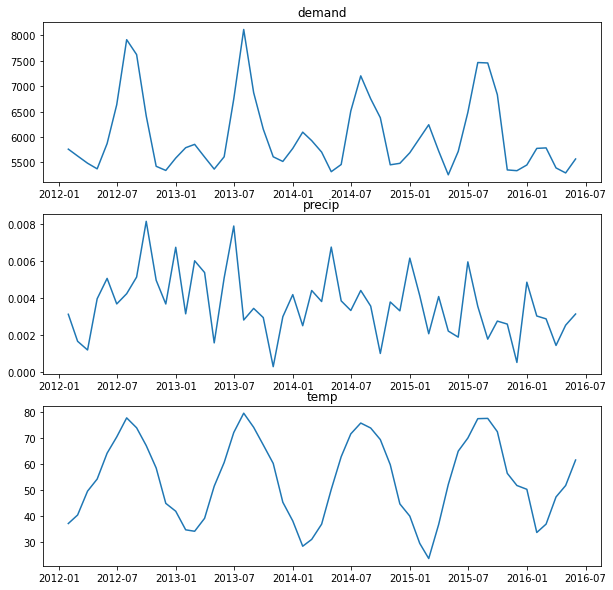

In [ ]:
results.plot();

11.  Plot of Prediction vs Actuals

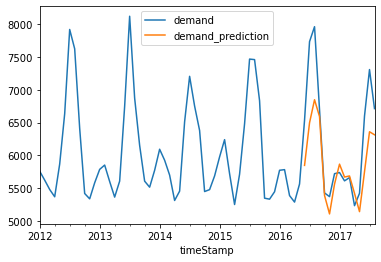

In [ ]:
pd.concat([df['demand'], df_forecast['demand_prediction']], axis=1).plot()
plt.show()

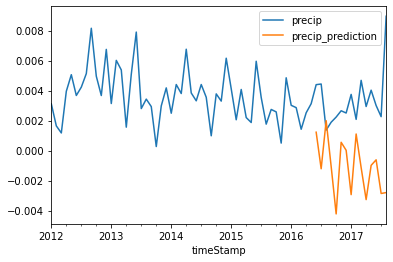

In [ ]:
pd.concat([df['precip'], df_forecast['precip_prediction']], axis=1).plot()
plt.show()

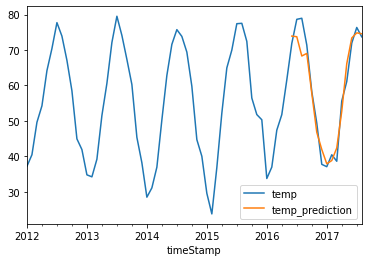

In [ ]:
pd.concat([df['temp'], df_forecast['temp_prediction']], axis=1).plot()
plt.show()